<a href="https://colab.research.google.com/github/KaroAntonio/climate-social-analysis/blob/main/notebooks/Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Data Wrangling

Here we import our datasets, explore the features we have to work with, get a feel for the distributions, and do some initial cleaning.

We want to keep in mind that we have the following goals for this analysis:
- Extract Topics from the Tweet Data (Unsupervised)
- Label Emotions for each tweet (Possibly supervised)
- Establish Association between Topics and Emotions

Our Datasets:
- Climate Tweets (15m)

These tweets have already been filtered from the broader twitter stream, so this dataset includes only tweets which include either 'climate change' or 'global warming'

Data Wrangling Steps Taken:

1. Load Dataset
2. Explore raw Dataset characteristics
3. Text Preprocessing
4. Tokenization
5. Token Preprocessing




In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 7.7 MB/s eta 0:00:00


In [2]:
!pip install joblib

In [3]:
from google.colab import drive
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import words
from itertools import chain
import pandas as pd
import numpy as np
import re
import emoji

In [4]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DRIVE_DIR = "/content/drive/MyDrive/Climate Social Analysis/data/"
TWEET_TEXT_DATA_PATH = f"{DRIVE_DIR}climate-change-twitter-dataset-tweet-data.csv"
TWEET_TIMESTAMPS_DATA_PATH = f"{DRIVE_DIR}climate-change-twitter-dataset-timestamps.csv"
PREPROCESSED_TEXT_PATH = f"{DRIVE_DIR}preprocessed_text.csv"

In [7]:
# Load tweets
text_df = pd.read_csv(TWEET_TEXT_DATA_PATH)

In [8]:
# Load Timestamp Metadata
timestamps_df = pd.read_csv(TWEET_TIMESTAMPS_DATA_PATH)

In [9]:
# What is the shape of our data?
text_df.shape

(15789411, 2)

In [10]:
# What are our cols?
text_df.columns

Index(['id', 'text'], dtype='object')

In [11]:
# Is there an 'id' for each row?
text_df['id'].nunique() == text_df.shape[0]

True

In [12]:
# Ok let's use 'id' for the index
text_df.set_index('id', inplace=True)

In [13]:
# What do our tweets look like?
pd.set_option('display.max_colwidth', 300)
text_df.sample(10)

,text
id,
1080829708714102784,"@mik61scot @theresa_may I can’t believe anyone still pays any attention to anything Nigel Lawson says. He’s a climate change denier who lives in France. He doesn’t even live in Britain, yet he’s telling us what to do? Ignore him."
637375797293023232,How will climate change affect business? http://t.co/I91FKlOJl2
460668362712829952,@missah8 been a crazy weather year damn global warming. Hopefully your winter will be a lot nicer then ours was Play Minecraft when I do :-)
6198431856,@dindacindyarini ada global warming cinnnnnnnnnnn hahaha
137854521572474880,“@fredtalbotitv: Just been to the post box to send some letters and did not even wear a fleece. Amazing for November .” #globalwarming
5625537940,@ZAIRE_ global warming = my guy
946851037528207360,RT @RepDonBeyer: 1: This isn’t how climate change works.\n\n2: We weren’t paying trillions of dollars. You didn’t understand the Paris Agreem…
1042959451333046274,RT @glenklatovsky: The Australian government has walked away from climate change action @350Australia #ClimateAction #auspol https://t.co/L…
1067798888868995072,"RT @Ocasio2018: Two weeks ago, we took a risk to support @sunrisemvmt‘s demand for Dems put climate change at the top of our agenda.\n\nWe we…"


In [14]:
# Ok how many duplicates do we have?
n_duplicates = text_df.duplicated().sum()
print(f"{n_duplicates} total duplicates")
print(f"{n_duplicates / text_df.shape[0] * 100}% duplicates")

6385951 total duplicates
40.444516898065416% duplicates


In [15]:
no_dupes_df = text_df.drop_duplicates()

In [16]:
# Do we have null values?
no_dupes_df.isnull().sum()

text    0
dtype: int64

<ipython-input-17-777e7e0b9bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dupes_df['text_length'] = no_dupes_df['text'].str.len()


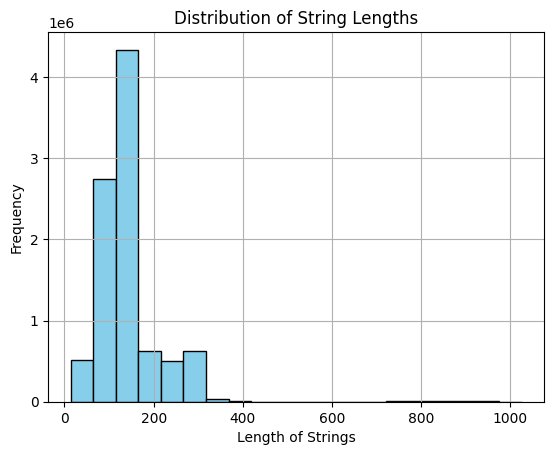

In [17]:
# What is the distribution of the length of the tweets?
# Calculate the length of each string in the 'text' column
no_dupes_df['text_length'] = no_dupes_df['text'].str.len()

# Plot the distribution of string lengths
plt.hist(no_dupes_df['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of String Lengths')
plt.xlabel('Length of Strings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This distribution makes sense since the original length of tweets was 140chars and then got increased to 280chars. So we see a big spike at 140 and then a tail up to 280.

In [18]:
# Merge in Timestamp Data
timestamps_df.set_index('id', inplace=True)

In [19]:
merged_df = no_dupes_df.merge(timestamps_df, left_index=True, right_index=True)

In [20]:
# What do the timestamps look like?
n_null_timestamps = merged_df['created_at'].isnull().sum()
print(f'N Null timestamps: {n_null_timestamps}')
print('Example Timestamp: ',merged_df.iloc[0]['created_at'])
print(merged_df['created_at'])

N Null timestamps: 0
Example Timestamp:  2006-06-06 16:06:42+00:00
id
6132                   2006-06-06 16:06:42+00:00
13275                  2006-07-23 21:52:30+00:00
23160                  2006-08-29 01:52:30+00:00
57868                  2006-11-07 02:46:52+00:00
304553                 2006-11-27 14:27:43+00:00
                                 ...            
1178906786792972288    2019-10-01 05:37:35+00:00
1178908472919769088    2019-10-01 05:44:17+00:00
1178908993022042112    2019-10-01 05:46:21+00:00
1178909001414610944    2019-10-01 05:46:23+00:00
1178910020626464768    2019-10-01 05:50:26+00:00
Name: created_at, Length: 9403460, dtype: object


In [21]:
# Convert 'created_at' into timestamp
merged_df['timestamp'] = pd.to_datetime(merged_df['created_at'])

In [22]:
# Group by year and count the number of rows per year
rows_per_year = merged_df.groupby(merged_df['timestamp'].dt.year).size()
print(rows_per_year)

timestamp
2006         12
2007       3597
2008      28946
2009     448153
2010     409508
2011     294049
2012     186319
2013     268237
2014     371940
2015    1206970
2016    1142734
2017    1488244
2018    2717974
2019     836777
dtype: int64


In [23]:
# Looks like the timestamps are working, so let's drop the 'created_at' str
merged_df.drop('created_at', axis=1, inplace=True)

## NLP Cleaning

At this point, having done the basic data cleanup, there is a lot of more nuanced language processing that can be done. Since we're going to be doing Topic analysis and Emotion Labelling, we can assume we're going to want to clean up the text and possibly already tokenize our strings.

### 1. Text Preprocessing

Our goal is to make the text as regular as possible and the token count (dictionary) should be as small as possible.
Some [basic text preprocessing](https://medium.com/@farhahahahahan/03-basic-text-preprocessing-nlp-90ea4469fb87) steps are:
- lowercasing
- remove html
- remove urls
- remove punctuation
- remove users
- remove hashtags (but we want to retain the actual hashtag text)
- remove emails
- remove low info chars

Some further token-based treatment that might be better done in EDA are:
- tokenization
- stopword removal
- spelling correction
- chatword translation
- handling emoji
- filtering for language (english)
- lemmatization / stemming


In [24]:
# Preprocess tweet text

def lower(text):
  return text.lower()

def remove_urls(text):
  # remove anything with a domain extension like ending
  text = re.sub(r'https?://\S+|http?://\S+', ' ', text)
  text = re.sub(r'\b\w+\.\w+\b',' ',text)
  text = re.sub(r'www\.[^\s]+', ' ', text)
  # remove words containing '://'
  text = re.sub(r'\b\S*:\/\/\S*\b', ' ', text)
  return text

def remove_html_tags(text):
  return re.sub('<.*?>', ' ', text)

def remove_user_mentions(text):
  return re.sub(r'@\w+', ' ', text)

def remove_email_addresses(text):
  return re.sub(r'\S+@\S+', ' ', text)

def remove_escape_sequences(text):
  return re.sub(r'[\r\n]+', ' ', text)

def translate_emoji(text):
  # translate emoji to text
  return emoji.demojize(text)

def remove_contraction(text):
  return re.sub(r'(?<=[a-zA-Z])\'(?=[a-zA-Z])', '', text)

def remove_low_info_chars(text):
  # remove chars that do not retain much 'meaning'
  # in this case we retain only a-z, 0-9, '!', and '?'
  return re.sub(r'[^0-9a-z\s!?]', ' ', text)

def preprocess(text):
  text = lower(text)
  text = remove_urls(text)
  text = remove_html_tags(text)
  text = remove_user_mentions(text)
  text = translate_emoji(text)
  text = remove_contraction(text)
  text = remove_escape_sequences(text)
  text = remove_low_info_chars(text)
  return text

def applyPreprocessing(sr):
  return sr.apply(preprocess)

In [25]:
# Let's test the preprocessing on a small sample
test = applyPreprocessing(merged_df['text'].sample(10000))

In [26]:
# Let's test to see if the output looks nice
# There are a lot of spaces and some of the tokens are a bit strange ie 80sf, but these are cases that can be handled on a token basis
for i, doc in enumerate(test.values[120:130]):
  print(i,doc)

0 tell   you cant stop  climatechange unless you  keepitintheground  no  coal  exports in wa  
1 rt catholics  what do you think of pope franciss encyclical on climate change?    
2 livesquad  thug mob lp the global warming coming soon!! kapaneli da don
3   a short balanced account of we need to act decisively on climate change  97  amazon  amp  shops
4   what could  cocacola do to fight  globalwarming?  openletter  buytheworldahope    
5       global warming must have got real bad if kenya is on the north coast of africa  dumbass
6 planting trees in extreme heat doesnt bring the heat down it doesnt even help the baby plants  they will die  plant them in jan  also  climate change is a gradual process with many factors  repair all of them  barbaadi 15 20 saal mein lagi hai  sahi bhi 15 20 saal mein hoga 
7 surprise!  brexiteers  amp  climate change deniers make up a cosy power network  however  their cliff is crumbling     
8 a weekend camp on climate change is educating people about ou

In [27]:
# There's a strange string 'lqiq3jwcut' that might be a part of a url or something, let's investigate
# It looks like strings starting with "://" should be treated as urls also
merged_df.loc[770113887576395776]

text           American pika vanishing from western US as 'habitat lost to climate change' https://t.co/CxUZFWhQhb ://t.co/LQIq3jwcUt RT @ClimateNexus
text_length                                                                                                                                        135
timestamp                                                                                                                    2016-08-29 04:20:33+00:00
Name: 770113887576395776, dtype: object

In [28]:
# How long would it take to run the preprocessing on all ~10m tweets?
# A: Running on 100k tweets is 19s, so 10m would be 100x that... a bit long
test = applyPreprocessing(merged_df['text'].sample(100000))

In [29]:
# We only have 2 cores, we're going to need a better runtime
# Ah, the GPU100 env has 8-12 cores, much better!

In [30]:
# Both of these took around 20s to run, something is not right with the parallelization
# How many cores do we have?
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores available:", num_cores)

Number of CPU cores available: 8


In [31]:
# Apply the function to each row of the DataFrame in parallel
# Runtime here is 4mins for the ~10m rows

# Define a function to apply preprocessing to each element of the Series in parallel
def apply_preprocessing_parallel(sr):
    n_jobs = -1 # use all cores
    return Parallel(n_jobs=n_jobs)(delayed(preprocess)(text) for text in sr)

preprocessed_texts = apply_preprocessing_parallel(merged_df['text'])

In [32]:
merged_df['preprocessed'] = preprocessed_texts

In [33]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9403460 entries, 6132 to 1178910020626464768
Data columns (total 4 columns):
 #   Column        Dtype              
---  ------        -----              
 0   text          object             
 1   text_length   int64              
 2   timestamp     datetime64[ns, UTC]
 3   preprocessed  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 616.7+ MB


In [34]:
merged_df.drop(columns=['text_length'], inplace=True)

In [35]:
# Tokenization
# Now that we've preprocessed out text, we want to tokenize it and explore what our token-space looks like
# We use a set for tokens as we treat our tokens as a bag-of-words

def handle_punctuation(text):
  # We want to buffer '!' and '?' with whitespace to treat them as tokens
  return text.replace('!', ' ! ').replace('?', ' ? ')

def tokenize(text):
  # We use the most basic tokenization approach, splitting by whitespace
  # this is reasonable since we've preprocessed all the punctuation and formatting
  return {token.strip() for token in text.split()}

def applyTokenization(sr):
  return sr.apply(handle_punctuation).apply(tokenize)

In [36]:
# Apply Tokenization
# runtime(100k)=1.23s so we would expect runtime(10m)=123s
%%time
tokens_sr = applyTokenization(merged_df['preprocessed'])
print(f'Tokenized {len(tokens_sr)} rows')

Tokenized 9403460 rows
CPU times: user 1min 31s, sys: 11.2 s, total: 1min 42s
Wall time: 1min 41s


In [37]:
# Check to make sure Tokenization went as expected
# The tokens look well formed, but there are definitely tokens that we want to clean
pd.set_option('display.max_colwidth', None)
tokens_sr.sample(10)

id
1040080155698491392                                                                                                                                                                                                         {number, hungry, people, climate, partly, to, is, growing, says, change, with, worldwide, un, blame, of}
438995831665209344                                                                                                                                                           {allow, mass, global, funding, pretty, immigrants, of, dont, we, warming, deportation, organisations, it, doesnt, with, agree, says, exist, stop, much}
2569020665                                                                                                                                                                                                     {make, change, alone, on, and, wants, clear, usage, climate, if, we, china, it, other, that, countries, to, lead, go}
145723922871103488    

In [38]:
# What is the distribution of our tokens?

tokens_list = tokens_sr.tolist()
all_tokens_list = [token for tokens in tokens_list for token in tokens]
freq_dist = FreqDist(all_tokens_list)

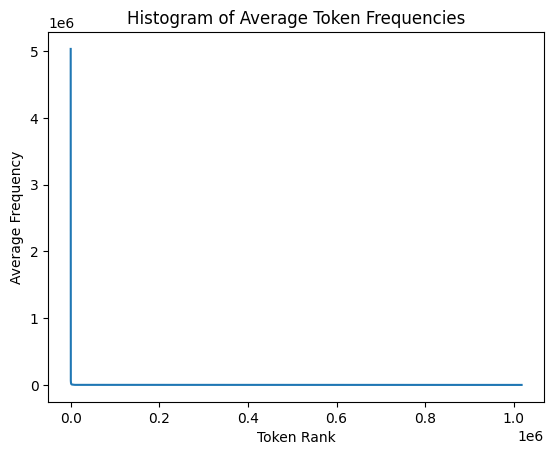

In [39]:
# Plot the distribution of token frequencies
token_freqs = sorted(list(freq_dist.values()), reverse=True)
x = np.arange(0, len(token_freqs), 1)

# Plot Frequency line
plt.plot(x, token_freqs)
plt.ylabel('Average Frequency')
plt.xlabel('Token Rank')
plt.title('Histogram of Average Token Frequencies')
plt.show()

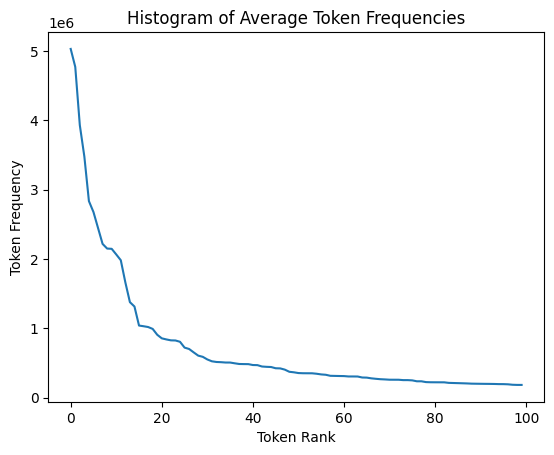

In [40]:
# Plot the Distribution of the top N most relevant tokens
# There's a huge right tail on the dist of tokens, with most being present only very few times and a very low % being... very present
# so let's plot only the top N

top_n = 100

token_freqs = sorted(list(freq_dist.values()), reverse=True)[:top_n]
x = np.arange(0, len(token_freqs), 1)

# Plot Frequency line
plt.plot(x, token_freqs)
plt.ylabel('Token Frequency')
plt.xlabel('Token Rank')
plt.title('Histogram of Average Token Frequencies')
plt.show()

In [41]:
# Some Token Distribution stats
print(f'There are {len(freq_dist)} unique tokens')
print(f'There are {len(all_tokens_list)} total tokens')
print(f'The ratio of unique to total tokens is: {len(freq_dist) / len(all_tokens_list)}')
print(f'Representative i-th freqs:')
token_freqs = sorted(list(freq_dist.values()), reverse=True)
for i in range(0,10000,1000):
  print(f'{i}th: {token_freqs[i]}')
for i in range(10000,100000,10000):
  print(f'{i}th: {token_freqs[i]}')
print(f"{token_freqs.index(3)}th: Index of first freq of 3")
print(f"{token_freqs.index(2)}th: Index of first freq of 2")
print(f"{token_freqs.index(1)}th: Index of first freq of 1")

There are 1017623 unique tokens
There are 161835925 total tokens
The ratio of unique to total tokens is: 0.006287991989417677
Representative i-th freqs:
0th: 5031565
1000th: 19371
2000th: 8491
3000th: 5013
4000th: 3347
5000th: 2456
6000th: 1886
7000th: 1481
8000th: 1203
9000th: 993
10000th: 839
20000th: 247
30000th: 117
40000th: 69
50000th: 46
60000th: 33
70000th: 25
80000th: 20
90000th: 16
232345th: Index of first freq of 3
292595th: Index of first freq of 2
431867th: Index of first freq of 1


In [42]:
# Based on the above, the top 2000 tokens seem to be the most significant.
# What are our top Freqs?
freq_dist.most_common(40)

[('climate', 5031565),
 ('change', 4772628),
 ('the', 3932664),
 ('to', 3478031),
 ('global', 2836366),
 ('warming', 2678661),
 ('of', 2448967),
 ('is', 2219356),
 ('climatechange', 2152095),
 ('and', 2148223),
 ('a', 2067096),
 ('in', 1983561),
 ('on', 1663992),
 ('?', 1378958),
 ('for', 1315966),
 ('that', 1041630),
 ('rt', 1031641),
 ('!', 1020312),
 ('it', 993007),
 ('are', 908541),
 ('about', 857163),
 ('we', 841333),
 ('you', 828145),
 ('i', 826319),
 ('this', 807287),
 ('with', 723438),
 ('be', 703490),
 ('not', 654585),
 ('by', 607570),
 ('from', 590378),
 ('will', 552498),
 ('how', 525889),
 ('have', 516098),
 ('as', 513163),
 ('its', 508265),
 ('but', 508030),
 ('s', 497109),
 ('more', 487176),
 ('what', 485754),
 ('at', 484979)]

In [43]:
# It looks like some tokens are single letters - which are they?
for i in range(ord('a'), ord('z') + 1):
  print(chr(i), freq_dist[chr(i)])

a 2067096
b 31741
c 52055
d 45454
e 30363
f 22360
g 12273
h 14388
i 826319
j 5896
k 7417
l 13559
m 54359
n 32345
o 34543
p 22004
q 10404
r 38414
s 497109
t 260378
u 58657
v 19736
w 60465
x 7797
y 21215
z 2102


In [44]:
# Let's explore what the tweets look like for some of these
# Let's roughly assume that tokens need to have a freq > 10000 to be 'relevant'
merged_df['tokens'] = tokens_sr

def get_examples_given_token(df, token):
  df_subset = df[df['tokens'].apply(lambda tokens: token in tokens)]['text']
  return(df_subset)

get_examples_given_token(merged_df, 's').sample(10)

id
1068154346981007360    Aftenpost (NO) "The Lancet Countdown report provides a stark reminder of the consequences for people’s health if we continue to procrastinate on climate change"- @JeniMiller @GCHAlliance https://t.co/yPxNNdthYn @Aftenposten @aft_verden @LancetCountdown #LancetClimate18 https://t.co/3iepXjbrkb
1039303837238976513                                                                                                     @MartyJBahamonde @Richard_Florida @fema It’s a good thing there’s no such thing as climate change - can you imagine how much worse it would be if it really existed...\n(She said, tongue-in-cheek).
672558771546247168                                                                                                                                                              @guardian @MSNBC @piersmorgan Based on @BillNye's evidence, gunfire responsible for 0.02% of #climatechange #NRA #2A https://t.co/bvSQUF9VlP
693854540131667968                            

In [45]:
# Process Tokens
# Now that we have tokens, we want to clean out some of the tokens that are 'clearly' non-informative
# There are several classes of tokens that

# Here we want to:
# 1. Remove common and 'meaningless' tokens ie stop-words
# 2. Translate some compound tokens

CUSTOM_STOPWORDS = [
    'rt', # retweet
    'amp', # from html for and
    's', # this seems to be mostly from 's contractions
]

translation_map = {
    'climatechange':{'climate','change'},
    'globalwarming':{'global','warming'},
    'actonclimate':{'act','on','climate'},
}

def remove_stopwords(tokens):
  return [token for token in tokens if token not in CUSTOM_STOPWORDS]

def translate_compound_tokens(tokens):
  new_tokens = set()
  for t in tokens:
    if t in translation_map:
      new_tokens.update(translation_map[t])
    else:
      new_tokens.add(t)
  return new_tokens

def processTokens(tokens):
  tokens = remove_stopwords(tokens)
  tokens = translate_compound_tokens(tokens)
  return tokens

def applyProcessTokens(sr):
  return sr.apply(processTokens)

In [46]:
# Apply Token Processing
processed_tokens_sr = applyProcessTokens(tokens_sr)

In [47]:
# Further data work will become much more compute intensive so lets see if a 10% subset of our corpus is representative enough to work with
subset_sr = tokens_sr.sample(1000000)
subset_all_tokens_list = [token for tokens in subset_sr.to_list() for token in tokens]
subset_freq_dist = FreqDist(subset_all_tokens_list)
subset_freq_dist.most_common(20)

[('climate', 534452),
 ('change', 507095),
 ('the', 417983),
 ('to', 369750),
 ('global', 301914),
 ('warming', 285171),
 ('of', 259787),
 ('is', 235982),
 ('climatechange', 229043),
 ('and', 227762),
 ('a', 219353),
 ('in', 210526),
 ('on', 176985),
 ('?', 146232),
 ('for', 139874),
 ('that', 110379),
 ('rt', 109489),
 ('!', 108734),
 ('it', 105461),
 ('are', 96607)]

In [48]:
# We compare the index of tokens in the original freq dist
# to the subset freq dist to get a sense of how much structure is preserved in the subset
vocab = [k for k,v in sorted(freq_dist.items(), key=lambda item: item[1], reverse=True)]
subset_vocab = [k for k,v in sorted(subset_freq_dist.items(), key=lambda item: item[1], reverse=True)]
N = 10000
epsilon = 1e-9
vocab_dist = []
for token in vocab:
  og_idx = vocab.index(token)
  subset_idx = subset_vocab.index(token) if token in subset_freq_dist else N
  vocab_dist.append(subset_idx - (og_idx))
  if og_idx > N:
    break

print(vocab_dist[:40])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [49]:
# Let's take a look at the rank diff for the first 500 tokens
for i in range(0,500,20):
  print(vocab_dist[i:(i+20)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, 0]
[0, 2, -1, -1, 0, 0, 0, 0, 0, 0, 2, 0, -2, 1, -1, 0, 0, 0, 0, 3]
[-1, 0, -2, 0, 0, 0, 0, 0, 0, 0, 2, -1, 1, -2, 1, -1, 0, 0, 1, 1]
[-2, 0, 0, 0, 0, 1, -1, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[-2, 0, 0, 0, 0, 0, 0, 0, 1, -1, 1, -1, 0, 0, 2, 3, -1, -3, -1, 1]
[-1, 1, -1, 1, -1, 0, 1, -1, 0, 1, -1, 0, 0, 2, 0, -2, 0, 2, 0, -2]
[0, 1, 3, -2, -1, -1, 2, 0, 1, 1, -4, 0, 0, 0, 0, 0, 5, 5, -2, 1]
[-2, 3, -3, 2, 2, -8, -3, 0, 1, 1, 1, -3, 2, -1, -1, 3, -1, 2, -1, -3]
[0, 0, 3, 1, -2, 4, 0, -4, 4, 2, -2, 4, 1, 1, -7, -5, 1, -1, 0, 2]
[0, -2, 5, -1, 6, 3, 0, -2, -5, -5, -1, 0, 2, 7, -1, -3, -1, -1, -1, -1]
[2, -2, 1, 5, 0, -4, 1, 2, -3, 5, -4, 11, -2, 2, -3, 3, -4, -4, -2, 12]
[0, -2, 1, -6, 4, -4, -2, -1, 6, 0, 0, -6, 5, -6, -1, -3, 2, -1, -3, 0]
[3, 0, 2, 8, 1, 2, 7, 1, -8, -3, -8, 1, 2, -3, -5, 8, 1, 8, 1,

In [50]:
# What is the average rank diff for each magnitudes of token list size?
for i in range(0,5):
  mag = 10 ** i
  print(f'{mag}: {sum(vocab_dist[:mag]) / mag}')

1: 0.0
10: 0.0
100: 0.02
1000: 0.238
10000: 17.7534


In [51]:
# We could look at the cosine distance between the two freq dists, or some other metric
# but for now, there seems to be enough retained structure in the subset to at least use it for exploration if necessary

In [52]:
merged_df['processed_tokens_str'] = processed_tokens_sr.apply(lambda tokens: ' '.join(tokens))

In [53]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9403460 entries, 6132 to 1178910020626464768
Data columns (total 5 columns):
 #   Column                Dtype              
---  ------                -----              
 0   text                  object             
 1   timestamp             datetime64[ns, UTC]
 2   preprocessed          object             
 3   tokens                object             
 4   processed_tokens_str  object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 688.5+ MB


In [78]:
# Save preprocessed DF
# We don't want to save the 'tokens' col as csv has a hard time handling lists/sets
# Save only some % of the total corpus
n_to_save = 1000000
# Save just processed_tokens_str
merged_df[['processed_tokens_str']].sample(n_to_save).to_csv(PREPROCESSED_TEXT_PATH, index=True)

In [80]:
loaded_preprocessed_df = pd.read_csv(PREPROCESSED_TEXT_PATH, index_col=0)

In [81]:
loaded_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 1046036754304827395 to 997414075406700544
Data columns (total 1 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   processed_tokens_str  1000000 non-null  object
dtypes: object(1)
memory usage: 15.3+ MB
